<a href="https://colab.research.google.com/github/areias/healthcare_fraud/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb -qqq


     |████████████████████████████████| 1.7 MB 5.3 MB/s 
     |████████████████████████████████| 143 kB 75.7 MB/s 
     |████████████████████████████████| 180 kB 72.8 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import wandb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean, std,  argmax

In [ ]:
wandb.login()

In [4]:
df_ben=pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
df_in=pd.read_csv('Train_Inpatientdata-1542865627584.csv')
df_out=pd.read_csv('Train_Outpatientdata-1542865627584.csv')
df=pd.read_csv('Train-1542865627584.csv')

In [5]:
df

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No
...,...,...
5405,PRV57759,No
5406,PRV57760,No
5407,PRV57761,No
5408,PRV57762,No


**Merging the data**

**Train**

In [6]:
df_in['Claim_type']='Inpatient'
df_out['Claim_type']='Outpatient'

In [7]:
final_df=pd.concat([df_in, df_out])
final_df=pd.merge(df_ben, final_df, on='BeneID')
final_df=pd.merge(final_df, df, on='Provider')

In [8]:
final_df.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Claim_type,PotentialFraud
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient,Yes
1,BENE12511,1944-09-01,NaN,1,1,0,39,510,12,12,2,2,2,2,2,2,1,1,1,2,2,0,0,1250,90,CLM724430,2009-12-11,2009-12-11,PRV55912,600,PHY420794,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V560,V4283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
2,BENE14577,1935-10-01,NaN,2,1,Y,33,70,12,12,2,1,1,2,2,2,2,1,2,2,1,0,0,2390,440,CLM567180,2009-09-07,2009-09-07,PRV55912,20,PHY381733,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
3,BENE15074,1932-06-01,NaN,2,1,0,39,470,12,12,1,2,1,2,2,2,1,1,2,2,2,0,0,870,210,CLM259984,2009-03-22,2009-03-22,PRV55912,30,PHY371570,NaN,PHY393406,NaN,NaN,0.0,NaN,NaN,V812,40390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
4,BENE16973,1932-05-01,NaN,1,1,0,39,310,12,12,1,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes


In [9]:
final_df.shape

(558211, 56)

In [10]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 56 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   DOB                              558211 non-null  object 
 2   DOD                              4131 non-null    object 
 3   Gender                           558211 non-null  int64  
 4   Race                             558211 non-null  int64  
 5   RenalDiseaseIndicator            558211 non-null  object 
 6   State                            558211 non-null  int64  
 7   County                           558211 non-null  int64  
 8   NoOfMonths_PartACov              558211 non-null  int64  
 9   NoOfMonths_PartBCov              558211 non-null  int64  
 10  ChronicCond_Alzheimer            558211 non-null  int64  
 11  ChronicCond_Heartfailure         558211 non-null  int64  
 12  Ch

**Usage of the date variables:**

In [11]:
# Convert the column Date into Datetime64 datatype
final_df['ClaimStartDt'] = pd.to_datetime(final_df['ClaimStartDt'], format = '%Y-%m-%d')
final_df['ClaimEndDt'] = pd.to_datetime(final_df['ClaimEndDt'], format = '%Y-%m-%d')

In [12]:
final_df['ClaimDuration']= final_df['ClaimEndDt']-final_df['ClaimStartDt']

## First Logistic model Try: 

In [13]:
model_df=final_df[['IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'ClaimDuration', 'Claim_type', 'InscClaimAmtReimbursed', 'PotentialFraud']]

In [14]:
model_df

,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimDuration,Claim_type,InscClaimAmtReimbursed,PotentialFraud
0,36000,3204,60,70,6 days,Inpatient,26000,Yes
1,0,0,1250,90,0 days,Outpatient,600,Yes
2,0,0,2390,440,0 days,Outpatient,20,Yes
3,0,0,870,210,0 days,Outpatient,30,Yes
4,24000,2136,450,200,0 days,Outpatient,50,Yes
...,...,...,...,...,...,...,...,...
558206,15000,1068,2540,400,0 days,Outpatient,1900,No
558207,0,0,14240,2810,20 days,Outpatient,2100,No
558208,0,0,640,350,0 days,Outpatient,10,No
558209,0,0,3220,1270,0 days,Outpatient,60,No


In [15]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   IPAnnualReimbursementAmt  558211 non-null  int64          
 1   IPAnnualDeductibleAmt     558211 non-null  int64          
 2   OPAnnualReimbursementAmt  558211 non-null  int64          
 3   OPAnnualDeductibleAmt     558211 non-null  int64          
 4   ClaimDuration             558211 non-null  timedelta64[ns]
 5   Claim_type                558211 non-null  object         
 6   InscClaimAmtReimbursed    558211 non-null  int64          
 7   PotentialFraud            558211 non-null  object         
dtypes: int64(5), object(2), timedelta64[ns](1)
memory usage: 38.3+ MB


In [16]:
feature_names = list(model_df.columns.values)
feature_names.pop(-1)
labels=list(model_df.PotentialFraud.unique())

In [ ]:
model_df['Claim_type']=pd.get_dummies(model_df['Claim_type'])
model_df['PotentialFraud']=pd.get_dummies(model_df['PotentialFraud'])

In [ ]:
model_df['ClaimDuration'] = model_df['ClaimDuration'].dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data = model_df.drop(['PotentialFraud'], axis=1)
target = model_df['PotentialFraud']

In [ ]:
final_df['PotentialFraud'].value_counts()

No     345415
Yes    212796
Name: PotentialFraud, dtype: int64

In [ ]:
target.value_counts()

1    345415
0    212796
Name: PotentialFraud, dtype: int64

**Splitting the data:**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=15, stratify=target)

In [ ]:
y_train.value_counts()

1    259061
0    159597
Name: PotentialFraud, dtype: int64

In [ ]:
y_test.value_counts()

1    86354
0    53199
Name: PotentialFraud, dtype: int64

In [ ]:
log_model = LogisticRegression(solver='liblinear', random_state=0)

In [ ]:
log_model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [ ]:
y_pred=log_model.predict(X_test)

In [ ]:
pred_prob = log_model.predict_proba(X_test)
pred_prob

array([[0.5 , 0.5 ],
       [0.56, 0.44],
       [0.37, 0.63],
       ...,
       [0.37, 0.63],
       [0.37, 0.63],
       [0.36, 0.64]])

**Confusion Matrix:**

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Test states')
    plt.xlabel('Predicted states')
    plt.tight_layout()

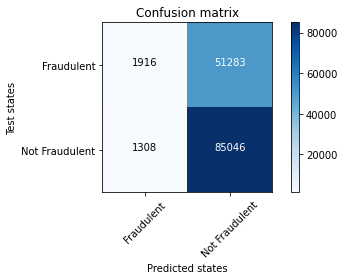

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Fraudulent', 'Not Fraudulent'],
                      title='Confusion matrix')

In [ ]:
accuracy_score(y_test, y_pred)

0.6231467614454723

In [ ]:
f1_score(y_test, y_pred)

0.7638301980842723

In [ ]:
wandb.init(project="Healthcare_fraud")

In [ ]:
wandb.sklearn.plot_confusion_matrix(y_test, y_pred, labels)

In [ ]:
wandb.sklearn.plot_classifier(log_model, X_train, X_test, y_train, y_test, y_pred, pred_prob, labels,
                                                         model_name='LR', feature_names=None)

wandb: 
wandb: Plotting LR.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged feature importances.
wandb: Logged confusion matrix.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged summary metrics.
wandb: Logged class proportions.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged calibration curve.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: Logged roc curve.
w

In [ ]:
wandb.sklearn.plot_roc(y_test, pred_prob, labels)

wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.


In [ ]:
wandb.sklearn.plot_learning_curve(log_model, X_test, y_test)

In [ ]:
wandb.sklearn.plot_class_proportions(y_train, y_test, labels)

In [ ]:
wandb.sklearn.plot_precision_recall(y_test, pred_prob, labels)

In [ ]:
wandb.sklearn.plot_feature_importances(log_model, feature_names)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
wandb.sklearn.plot_summary_metrics(log_model, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


## New logistic regression model: 

In [18]:
groups1 = final_df.groupby(['Provider'], as_index=False)['ClaimID'].count()
groups1

,Provider,ClaimID
0,PRV51001,25
1,PRV51003,132
2,PRV51004,149
3,PRV51005,1165
4,PRV51007,72
...,...,...
5405,PRV57759,28
5406,PRV57760,22
5407,PRV57761,82
5408,PRV57762,1


In [19]:
groups2 = final_df.groupby(['Provider'], as_index=False)['InscClaimAmtReimbursed'].mean()
groups2

,Provider,InscClaimAmtReimbursed
0,PRV51001,4185.600000
1,PRV51003,4588.409091
2,PRV51004,350.134228
3,PRV51005,241.124464
4,PRV51007,468.194444
...,...,...
5405,PRV57759,380.000000
5406,PRV57760,216.818182
5407,PRV57761,225.243902
5408,PRV57762,1900.000000


In [20]:
#What is the most common claim type for each provider
groups4=final_df.groupby(['Provider', 'PotentialFraud'], as_index=False)['Claim_type'].agg(pd.Series.mode)
groups4

,Provider,PotentialFraud,Claim_type
0,PRV51001,No,Outpatient
1,PRV51003,Yes,Outpatient
2,PRV51004,No,Outpatient
3,PRV51005,Yes,Outpatient
4,PRV51007,No,Outpatient
...,...,...,...
5405,PRV57759,No,Outpatient
5406,PRV57760,No,Outpatient
5407,PRV57761,No,Outpatient
5408,PRV57762,No,Outpatient


In [21]:
final_df['ClaimDuration'] = final_df['ClaimDuration'].dt.days
groups5 = final_df.groupby(['Provider'], as_index=False)['ClaimDuration'].mean()
groups5

,Provider,ClaimDuration
0,PRV51001,1.440000
1,PRV51003,3.674242
2,PRV51004,1.429530
3,PRV51005,1.088412
4,PRV51007,0.958333
...,...,...
5405,PRV57759,2.142857
5406,PRV57760,0.318182
5407,PRV57761,1.390244
5408,PRV57762,0.000000


In [23]:
Alz = final_df.loc[final_df['ChronicCond_Alzheimer']==1].groupby(['Provider'], as_index=False)['ChronicCond_Alzheimer'].count()
Alz

,Provider,ChronicCond_Alzheimer
0,PRV51001,15
1,PRV51003,56
2,PRV51004,64
3,PRV51005,426
4,PRV51007,26
...,...,...
5084,PRV57758,2
5085,PRV57759,14
5086,PRV57760,3
5087,PRV57761,36


In [24]:
Dep = final_df.loc[final_df['ChronicCond_Depression']==1].groupby(['Provider'], as_index=False)['ChronicCond_Depression'].count()
Dep

,Provider,ChronicCond_Depression
0,PRV51001,9
1,PRV51003,54
2,PRV51004,63
3,PRV51005,485
4,PRV51007,29
...,...,...
5116,PRV57757,9
5117,PRV57759,9
5118,PRV57760,7
5119,PRV57761,38


In [25]:
heart = final_df.loc[final_df['ChronicCond_Heartfailure']==1].groupby(['Provider'], as_index=False)['ChronicCond_Heartfailure'].count()
heart

,Provider,ChronicCond_Heartfailure
0,PRV51001,19
1,PRV51003,80
2,PRV51004,88
3,PRV51005,680
4,PRV51007,40
...,...,...
5249,PRV57758,2
5250,PRV57759,20
5251,PRV57760,11
5252,PRV57761,56


### Merging the new variables

In [27]:
from functools import reduce
pdList = [groups1, groups2, groups4, groups5, Alz, Dep, heart]  # List of dataframes
new_df = reduce(lambda  left,right: pd.merge(left, right, how="outer" , on=['Provider']),pdList).fillna(0)

In [30]:
new_df

,Provider,ClaimID,InscClaimAmtReimbursed,PotentialFraud,Claim_type,ClaimDuration,ChronicCond_Alzheimer,ChronicCond_Depression,ChronicCond_Heartfailure
0,PRV51001,25,4185.600000,No,Outpatient,1.440000,60.000000,36.000000,76.000000
1,PRV51003,132,4588.409091,Yes,Outpatient,3.674242,42.424242,40.909091,60.606061
2,PRV51004,149,350.134228,No,Outpatient,1.429530,42.953020,42.281879,59.060403
3,PRV51005,1165,241.124464,Yes,Outpatient,1.088412,36.566524,41.630901,58.369099
4,PRV51007,72,468.194444,No,Outpatient,0.958333,36.111111,40.277778,55.555556
...,...,...,...,...,...,...,...,...,...
5405,PRV57759,28,380.000000,No,Outpatient,2.142857,50.000000,32.142857,71.428571
5406,PRV57760,22,216.818182,No,Outpatient,0.318182,13.636364,31.818182,50.000000
5407,PRV57761,82,225.243902,No,Outpatient,1.390244,43.902439,46.341463,68.292683
5408,PRV57762,1,1900.000000,No,Outpatient,0.000000,0.000000,0.000000,0.000000


In [28]:
new_df['ChronicCond_Alzheimer']=new_df['ChronicCond_Alzheimer']*100/new_df['ClaimID']
new_df['ChronicCond_Depression']=new_df['ChronicCond_Depression']*100/new_df['ClaimID']
new_df['ChronicCond_Heartfailure']=new_df['ChronicCond_Heartfailure']*100/new_df['ClaimID']

In [29]:
neo_df=new_df.copy()

In [32]:
new_df = new_df.rename(columns={'ClaimID': 'nb_claims', 'InscClaimAmtReimbursed': 'Avg_InscClaimAmtReimbursed', 
                                 'Claim_type': 'Most_Common_Claim_Type',
                                'ClaimDuration': 'AvgClaimDuration', 'ChronicCond_Alzheimer': 'Alz_Claims_Ratio',
                                'ChronicCond_Depression': 'Dep_Claims_Ratio', 'ChronicCond_Heartfailure':'Heart_Claims_Ratio'})
new_df = new_df[['nb_claims',	'Avg_InscClaimAmtReimbursed', 'Most_Common_Claim_Type',	'AvgClaimDuration',	'Alz_Claims_Ratio','Dep_Claims_Ratio', 'Heart_Claims_Ratio', 'PotentialFraud']]
new_df

,nb_claims,Avg_InscClaimAmtReimbursed,Most_Common_Claim_Type,AvgClaimDuration,Alz_Claims_Ratio,Dep_Claims_Ratio,Heart_Claims_Ratio,PotentialFraud
0,25,4185.600000,Outpatient,1.440000,60.000000,36.000000,76.000000,No
1,132,4588.409091,Outpatient,3.674242,42.424242,40.909091,60.606061,Yes
2,149,350.134228,Outpatient,1.429530,42.953020,42.281879,59.060403,No
3,1165,241.124464,Outpatient,1.088412,36.566524,41.630901,58.369099,Yes
4,72,468.194444,Outpatient,0.958333,36.111111,40.277778,55.555556,No
...,...,...,...,...,...,...,...,...
5405,28,380.000000,Outpatient,2.142857,50.000000,32.142857,71.428571,No
5406,22,216.818182,Outpatient,0.318182,13.636364,31.818182,50.000000,No
5407,82,225.243902,Outpatient,1.390244,43.902439,46.341463,68.292683,No
5408,1,1900.000000,Outpatient,0.000000,0.000000,0.000000,0.000000,No


In [33]:
new_df['PotentialFraud'].value_counts()

No     4904
Yes     506
Name: PotentialFraud, dtype: int64

In [34]:
feature_names = list(new_df.columns.values)
feature_names.pop(-1)
labels=list(new_df.PotentialFraud.unique())

In [35]:
new_df.dtypes

nb_claims                       int64
Avg_InscClaimAmtReimbursed    float64
Most_Common_Claim_Type         object
AvgClaimDuration              float64
Alz_Claims_Ratio              float64
Dep_Claims_Ratio              float64
Heart_Claims_Ratio            float64
PotentialFraud                 object
dtype: object

### One-hot encoding: 

In [36]:
new_df['Most_Common_Claim_Type']=new_df['Most_Common_Claim_Type'].astype('str')
new_df["Most_Common_Claim_Type"].replace({"Inpatient": 0, "Outpatient": 1, "['Inpatient' 'Outpatient']": 2}, inplace=True)

In [37]:
new_df["PotentialFraud"].replace({"No": "0", "Yes": "1"}, inplace=True)
new_df['PotentialFraud']=new_df['PotentialFraud'].astype('int')

### Splitting the data: 

In [38]:
data = new_df.drop(['PotentialFraud'], axis=1)
target = new_df['PotentialFraud']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=15, stratify=target)

### Modeling: 

#### Logistic Regression: 

In [40]:
log_model = LogisticRegression(solver='liblinear', random_state=0)

In [41]:
log_model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [42]:
log_pred=log_model.predict(X_test)

In [43]:
pred_prob = log_model.predict_proba(X_test)
pred_prob

array([[0.77550109, 0.22449891],
       [0.96899384, 0.03100616],
       [0.96833986, 0.03166014],
       ...,
       [0.96864472, 0.03135528],
       [0.96978993, 0.03021007],
       [0.95841318, 0.04158682]])

In [44]:
accuracy_score(y_test, log_pred)

0.9061345158906134

In [45]:
f1_score(y_test, log_pred)

0.26589595375722547

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Test states')
    plt.xlabel('Predicted states')
    plt.tight_layout()

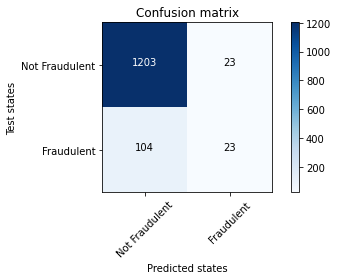

In [47]:
cnf_matrix = confusion_matrix(y_test, log_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[ 'Not Fraudulent', 'Fraudulent',],
                      title='Confusion matrix')

In [48]:
print(metrics.classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1226
           1       0.50      0.18      0.27       127

    accuracy                           0.91      1353
   macro avg       0.71      0.58      0.61      1353
weighted avg       0.88      0.91      0.89      1353



**ROC Curve**

In [49]:
pred_prob

array([[0.78, 0.22],
       [0.97, 0.03],
       [0.97, 0.03],
       ...,
       [0.97, 0.03],
       [0.97, 0.03],
       [0.96, 0.04]])

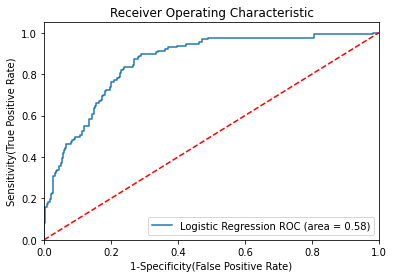

In [50]:
##check! 
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:,1])
auc = metrics.roc_auc_score(y_test,log_pred)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('Logistic Regression', auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()  

In [51]:
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.059303


In [52]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

probs = pred_prob[:, 1]
f1_score(y_test, to_labels(probs, best_thresh))

0.38319327731092434

#### Random Forest: 

In [53]:
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [54]:
rf_pred = rf.predict(X_test)

In [55]:
accuracy_score(y_test, rf_pred)

0.9275683665927569

In [56]:
f1_score(y_test, rf_pred)

0.4842105263157895

In [57]:
print(metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1226
           1       0.73      0.36      0.48       127

    accuracy                           0.93      1353
   macro avg       0.83      0.67      0.72      1353
weighted avg       0.92      0.93      0.92      1353



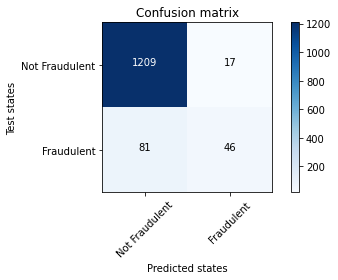

In [58]:
cnf_matrix = confusion_matrix(y_test, rf_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[ 'Not Fraudulent', 'Fraudulent'],
                      title='Confusion matrix')

#### Random Forest Cross Validation

In [59]:
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('F1_score: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

F1_score: 0.528 (0.077)


In [60]:
n_scores

array([0.45, 0.47, 0.35, 0.49, 0.58, 0.58, 0.6 , 0.56, 0.57, 0.41, 0.54,
       0.5 , 0.47, 0.47, 0.49, 0.52, 0.68, 0.65, 0.6 , 0.54, 0.54, 0.54,
       0.54, 0.38, 0.6 , 0.55, 0.43, 0.55, 0.54, 0.66])

#### Neo4j Model:

In [61]:
neo_df

,Provider,ClaimID,InscClaimAmtReimbursed,PotentialFraud,Claim_type,ClaimDuration,ChronicCond_Alzheimer,ChronicCond_Depression,ChronicCond_Heartfailure
0,PRV51001,25,4185.600000,No,Outpatient,1.440000,60.000000,36.000000,76.000000
1,PRV51003,132,4588.409091,Yes,Outpatient,3.674242,42.424242,40.909091,60.606061
2,PRV51004,149,350.134228,No,Outpatient,1.429530,42.953020,42.281879,59.060403
3,PRV51005,1165,241.124464,Yes,Outpatient,1.088412,36.566524,41.630901,58.369099
4,PRV51007,72,468.194444,No,Outpatient,0.958333,36.111111,40.277778,55.555556
...,...,...,...,...,...,...,...,...,...
5405,PRV57759,28,380.000000,No,Outpatient,2.142857,50.000000,32.142857,71.428571
5406,PRV57760,22,216.818182,No,Outpatient,0.318182,13.636364,31.818182,50.000000
5407,PRV57761,82,225.243902,No,Outpatient,1.390244,43.902439,46.341463,68.292683
5408,PRV57762,1,1900.000000,No,Outpatient,0.000000,0.000000,0.000000,0.000000


In [62]:
neo_df = neo_df.rename(columns={'ClaimID': 'nb_claims', 'InscClaimAmtReimbursed': 'Avg_InscClaimAmtReimbursed', 
                                 'Claim_type': 'Most_Common_Claim_Type',
                                'ClaimDuration': 'AvgClaimDuration', 'ChronicCond_Alzheimer': 'Alz_Claims_Ratio',
                                'ChronicCond_Depression': 'Dep_Claims_Ratio', 'ChronicCond_Heartfailure':'Heart_Claims_Ratio'})
neo_df

,Provider,nb_claims,Avg_InscClaimAmtReimbursed,PotentialFraud,Most_Common_Claim_Type,AvgClaimDuration,Alz_Claims_Ratio,Dep_Claims_Ratio,Heart_Claims_Ratio
0,PRV51001,25,4185.600000,No,Outpatient,1.440000,60.000000,36.000000,76.000000
1,PRV51003,132,4588.409091,Yes,Outpatient,3.674242,42.424242,40.909091,60.606061
2,PRV51004,149,350.134228,No,Outpatient,1.429530,42.953020,42.281879,59.060403
3,PRV51005,1165,241.124464,Yes,Outpatient,1.088412,36.566524,41.630901,58.369099
4,PRV51007,72,468.194444,No,Outpatient,0.958333,36.111111,40.277778,55.555556
...,...,...,...,...,...,...,...,...,...
5405,PRV57759,28,380.000000,No,Outpatient,2.142857,50.000000,32.142857,71.428571
5406,PRV57760,22,216.818182,No,Outpatient,0.318182,13.636364,31.818182,50.000000
5407,PRV57761,82,225.243902,No,Outpatient,1.390244,43.902439,46.341463,68.292683
5408,PRV57762,1,1900.000000,No,Outpatient,0.000000,0.000000,0.000000,0.000000


In [63]:
grp=final_df.groupby(['Provider'], as_index=False).agg({"BeneID": "nunique"})
neo_df=pd.merge(neo_df, grp, on='Provider')

In [64]:
community =pd.read_csv('export.csv')
community = community.rename(columns={'p.idx': 'Provider'})
community

,Provider,p2.community,total
0,PRV55215,93322,238
1,PRV56444,68977,152
2,PRV55169,93322,134
3,PRV57103,122953,123
4,PRV57209,78970,101
...,...,...,...
52248,PRV52032,123382,1
52249,PRV52032,11441,1
52250,PRV52032,27984,1
52251,PRV52032,130287,1


In [65]:
filtered=community.loc[community['total']>10]

In [66]:
pv=filtered.pivot(index='Provider',columns='p2.community')[['total']].fillna(0)

In [67]:
pv

total                       ...                            
p2.community 452    1080   3218   6493    ... 144479 144773 144879 145260
Provider                                  ...                            
PRV51003        0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
PRV51004        0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
PRV51011        0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
PRV51012        0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
PRV51017        0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
...             ...    ...    ...    ...  ...    ...    ...    ...    ...
PRV57643        0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
PRV57647        0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
PRV57709        0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
PRV57715        0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0
PRV57718        0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0

[786 rows x 109 columns]

In [68]:
final=pd.merge(neo_df, pv, on='Provider', how='outer').fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  """Entry point for launching an IPython kernel.


In [69]:
final

,Provider,nb_claims,Avg_InscClaimAmtReimbursed,PotentialFraud,Most_Common_Claim_Type,AvgClaimDuration,Alz_Claims_Ratio,Dep_Claims_Ratio,Heart_Claims_Ratio,BeneID,"(total, 452)","(total, 1080)","(total, 3218)","(total, 6493)","(total, 11742)","(total, 13590)","(total, 16791)","(total, 17142)","(total, 20503)","(total, 20908)","(total, 25297)","(total, 25765)","(total, 31338)","(total, 31354)","(total, 31447)","(total, 31802)","(total, 32423)","(total, 32862)","(total, 33771)","(total, 33825)","(total, 34889)","(total, 35233)","(total, 38529)","(total, 44219)","(total, 50424)","(total, 50670)","(total, 52986)","(total, 53284)","(total, 54064)","(total, 64879)",...,"(total, 107604)","(total, 108730)","(total, 108764)","(total, 111249)","(total, 113511)","(total, 114354)","(total, 115726)","(total, 115937)","(total, 116452)","(total, 116534)","(total, 116875)","(total, 117645)","(total, 117941)","(total, 119091)","(total, 119169)","(total, 121252)","(total, 121387)","(total, 121612)","(total, 121850)","(total, 122953)","(total, 123149)","(total, 126614)","(total, 128070)","(total, 128725)","(total, 129500)","(total, 131024)","(total, 131641)","(total, 131841)","(total, 132355)","(total, 134763)","(total, 135682)","(total, 136693)","(total, 138835)","(total, 142377)","(total, 142966)","(total, 144328)","(total, 144479)","(total, 144773)","(total, 144879)","(total, 145260)"
0,PRV51001,25,4185.600000,No,Outpatient,1.440000,60.000000,36.000000,76.000000,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PRV51003,132,4588.409091,Yes,Outpatient,3.674242,42.424242,40.909091,60.606061,117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PRV51004,149,350.134228,No,Outpatient,1.429530,42.953020,42.281879,59.060403,138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PRV51005,1165,241.124464,Yes,Outpatient,1.088412,36.566524,41.630901,58.369099,495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PRV51007,72,468.194444,No,Outpatient,0.958333,36.111111,40.277778,55.555556,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,28,380.000000,No,Outpatient,2.142857,50.000000,32.142857,71.428571,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5406,PRV57760,22,216.818182,No,Outpatient,0.318182,13.636364,31.818182,50.0

In [70]:
final=final.drop(['Provider'], axis=1)

In [71]:
final['Most_Common_Claim_Type']=final['Most_Common_Claim_Type'].astype('str')

In [72]:
final["Most_Common_Claim_Type"].replace({"Inpatient": 0, "Outpatient": 1, "['Inpatient' 'Outpatient']": 2}, inplace=True)

In [73]:
final["Most_Common_Claim_Type"].value_counts()

1    4796
0     587
2      27
Name: Most_Common_Claim_Type, dtype: int64

In [74]:
final['Most_Common_Claim_Type']=final['Most_Common_Claim_Type'].astype('int')

In [75]:
final["PotentialFraud"].replace({"No": "0", "Yes": "1"}, inplace=True)
final['PotentialFraud']=final['PotentialFraud'].astype('int')

In [76]:
data = final.drop(['PotentialFraud'], axis=1)
target = final['PotentialFraud']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=15, stratify=target)

In [78]:
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [79]:
rf_pred = rf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'tuple']. An error will be raised in 1.2.
  FutureWarning,


In [80]:
accuracy_score(y_test, rf_pred)

0.9238728750923872

In [81]:
f1_score(y_test, rf_pred)

0.455026455026455

In [82]:
print(metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1226
           1       0.69      0.34      0.46       127

    accuracy                           0.92      1353
   macro avg       0.81      0.66      0.71      1353
weighted avg       0.91      0.92      0.91      1353



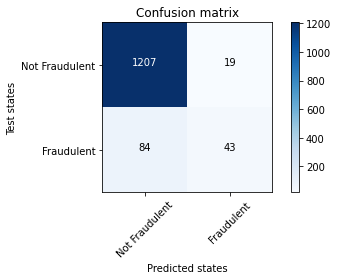

In [83]:
cnf_matrix = confusion_matrix(y_test, rf_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[ 'Not Fraudulent', 'Fraudulent'],
                      title='Confusion matrix')